In [1]:
%matplotlib inline
import matplotlib.pyplot as plt #plotting
import numpy as np #array handling
from PIL import Image, ImageOps #image loading

from scipy import signal #convolution

from ipywidgets import interact, interactive, fixed

In [2]:
def generate_gabor(size, shift, sigma, rotation, phase_shift, frequency):
    radius = (int((size[0]/2.0)), int((size[1]/2.0)))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    x = x - int(shift[0])
    y = y - int(shift[1])
    x = x * frequency
    y = y * frequency
    tmp = x * np.cos(rotation) + y * np.sin(rotation) + phase_shift
    radius = (int(size[0]/2.0), int(size[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    
    x = x - int(shift[0])
    y = y - int(shift[1])
    x1 = x * np.cos(rotation) + y * np.sin(rotation)
    y1 = -x * np.sin(rotation) + y * np.cos(rotation)
    
    sinusoid = np.cos(tmp)
    
    gauss = np.e * np.exp(np.negative(0.5 * ((x1**2 / sigma[0]**2) + (y1**2 / sigma[1]**2)))) 
    gauss = gauss / 2*np.pi * sigma[0] * sigma[1]
    
    gabor = gauss * sinusoid
    return gabor

def open_norm(path,verbose=False):
    raw = np.array(Image.open(path).convert("L"))
    norm = (raw - np.mean(raw)) / np.std(raw)
    
    if verbose:
        return raw, norm
    else:
        return norm
    
def linear_convolution(center, slide): 
    if (center.shape != slide.shape):
        return
    padded_slide = np.zeros((center.shape[0],center.shape[1]*3))
    padded_slide[0:,center.shape[1]:center.shape[1]*2] = center
    #plt.imshow(padded_slide,origin="lower")
    #plt.show()
    estimate = np.zeros([center.shape[1]*2])
    for x in range(center.shape[1]*2):
        dot = np.sum(padded_slide[0:,0+x:center.shape[1]+x] * slide)
        estimate[x] = dot
    #plt.plot(estimate)
    #plt.show()
    print(np.abs(np.argmax(np.abs(estimate))-center.shape[1]))
    return np.abs(estimate)
    
def double_convolve(normal, shifted, image, pupillary_distance):
    
    normal_convolved = signal.convolve2d(image, normal, boundary='symm', mode='same')
    shifted_convolved = signal.convolve2d(image, shifted, boundary='symm', mode='same')
    
    return_shape = image.shape
    
    realigned = np.zeros(return_shape)
    print(realigned.shape)

    


    normal_convolved = normal_convolved[0:,0:-pupillary_distance]
    shifted_convolved = shifted_convolved[0:,pupillary_distance:]
    

    
    
    diff = np.subtract(normal_convolved, shifted_convolved)
    mul = normal_convolved * shifted_convolved
    #plt.imshow(mul,cmap="nipy_spectral")
    #plt.show()
    
    #REMOVE BELOW COMMENTS TO THRESH SUBHALF VALUES
    #low_values_flags = mul <= 0 #mul.max()*0.5  # Where values are low
    #mul[low_values_flags] = 0  # All low values set to 0
    realigned[0:,pupillary_distance:] = mul
    return np.abs(realigned)

(600, 600)
5


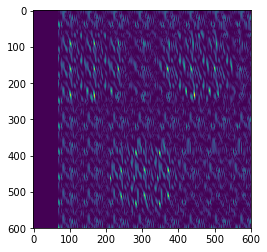

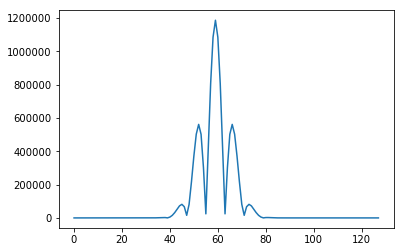

6108063 175424 433542 80656458


In [3]:
image = open_norm("shift5_70patch.png",verbose=False)
norm = generate_gabor((64, 64),(0.0, 0),(4.5, 7.59),3.0,3.14,0.4)
shifted = generate_gabor((64, 64),(5.0, 0),(4.5, 7.59),3.0,3.14,0.4)
test = double_convolve(norm, shifted, image,70)

disparity_map = linear_convolution(norm, shifted)
plt.imshow(test)
plt.show()

plt.plot(disparity_map)
plt.show()
pupillary_distance = 70


dm = np.array(Image.open("dm.png").convert("L"))
inv = np.array(Image.open("inverted_dm.png").convert("L"))

act = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
sv = Image.fromarray(act)
sv = ImageOps.colorize(sv, (0,0,0), (0,255,0))
sv.save("act.png")

act_inside = np.bitwise_and(dm, act)
rescaled = (255.0 / act_inside.max() * (act_inside - act_inside.min())).astype(np.uint8)
sv = Image.fromarray(rescaled)
sv.save("act_inside.png")

act_outside = np.bitwise_and(inv, act)
rescaled = (255.0 / act_outside.max() * (act_outside - act_outside.min())).astype(np.uint8)
sv = Image.fromarray(rescaled)
sv.save("act_outside.png")


sum_outside_act = np.sum(act_outside[0:,pupillary_distance:])
sum_inside_act = np.sum(act_inside[0:,pupillary_distance:])
sum_dm = np.sum(dm[0:,pupillary_distance:])
sum_inv = np.sum(inv[0:,pupillary_distance:])

'''

sum_outside_act = np.sum(np.where(act_outside > 0, 1, 0))
sum_inside_act = np.sum(np.where(act_inside > 0, 1, 0))
sum_dm = np.sum(np.where(dm > 0, 1, 0))
sum_inv = np.sum(np.where(inv > 0, 1, 0))
'''

print(sum_outside_act,sum_inside_act, sum_dm, sum_inv)




(128,)
(600, 600)


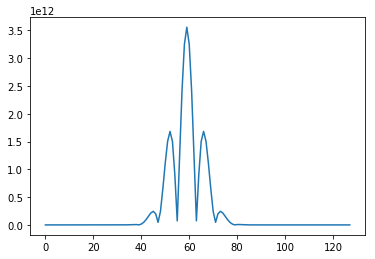

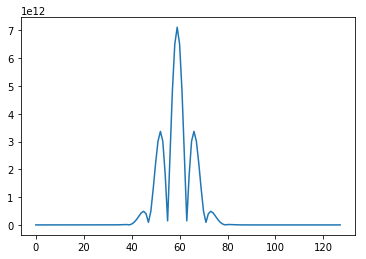

In [4]:
print(disparity_map.shape)
print(test.shape)

#test * disparity_map

t = np.zeros([test.shape[0],test.shape[1],disparity_map.shape[0]])
t[:,:] = disparity_map



for x in range(test.shape[0]):
    for y in range(test.shape[1]):
        t[x,y] = test[x,y] * t[x,y]

w = t + t
plt.plot(t[120,120])
plt.show()
plt.plot(w[120,120])
plt.show()

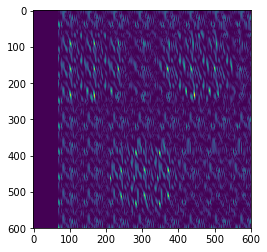

In [6]:
depth_predict = np.zeros([t.shape[0],t.shape[1]])

for x in range(t.shape[0]):
    for y in range(t.shape[1]):
        depth_predict[x,y] = t[x,y][np.abs(np.argmax(np.abs(t[x,y]))-64)]
        
plt.imshow(depth_predict)
plt.show()


In [9]:
print(depth_predict[0,0])


0.0


In [46]:
pupillary_distance = 70

signal_flags = dm[0:,pupillary_distance:] > 0

noise_flags = inv[0:,pupillary_distance:] > 0
    
den_inside = act_inside[0:,pupillary_distance:]
den_outside = act_outside[0:,pupillary_distance:]




print(np.mean(den_inside[signal_flags]))
print(np.mean(den_outside[noise_flags]))

print(np.std(den_inside[signal_flags]))
print(np.std(den_outside[noise_flags]))

dprime = (np.mean(den_inside[signal_flags]) - np.mean(den_outside[noise_flags])) / (np.sqrt((0.5 * (np.power(np.std(den_inside[signal_flags]),2) + np.power(np.std(den_outside[noise_flags]),2)))))
print(dprime)

#density of activity??


#print("coverage:")
#print(sum_inside_act / sum_dm)
#print()
#print("activity ratio (outside/inside):")
#print(sum_outside_act / sum_inside_act)

#RUN SENSATIVITY INDEX

27.5754070589
18.649640738
33.4930998683
20.477734379
0.321544828625


In [9]:
def demo_gabor(shift_x, shift_y, sigma_x, sigma_y, rotation, phase_shift, frequency,pd):
    size=(64,64)
    shift=(shift_x,shift_y)
    sigma=(sigma_x,sigma_y)
    static = generate_gabor(size, shift, sigma, rotation, phase_shift, frequency)
    plt.imshow(static, origin="lower")
    plt.show()
    
    #tested pupil distance shift -- remove pd from function for basic gabor demo
    
    n_shift=(shift_x+pd,shift_y)
    shifted = generate_gabor(size, n_shift, sigma, rotation, phase_shift, frequency)
    plt.imshow(shifted, origin="lower")
    plt.show()
    print(size, shift, sigma, rotation, phase_shift, frequency)
    print(size, n_shift, sigma, rotation, phase_shift, frequency)

    
    #end
    
    #Start explorative linear convolution
    linear_convolution(static, shifted)

interact(demo_gabor, phase_shift=(0,2*np.pi,0.01), shift_x=(-24,24,0.1),shift_y=(-24,24,0.1),sigma_x=(0,20,0.01),sigma_y=(0,20,0.01),rotation=(0,np.pi,0.01),frequency=(0.1,3.0,0.1),pd=(-100,100,1))




<function __main__.demo_gabor>

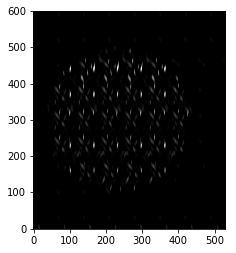

In [20]:
image = open_norm("data/shift5_patch70.png",verbose=False)
sum_array = np.zeros([600,530])

for y_shift in np.arange(-5, 5, 1):

    for rotation in np.arange(2.5, 3.14, 0.1):
        norm = generate_gabor((64, 64),(0.0, y_shift),(4.5, 7.59),rotation,3.14,0.4)
        shifted = generate_gabor((64, 64),(5.0, y_shift),(4.5, 7.59),rotation,3.14,0.4)
        test = double_convolve(norm, shifted, image,70)
        sum_array = np.add(sum_array,test)

    for rotation in np.arange(0.0, 0.85, 0.1):
        norm = generate_gabor((64, 64),(0.0, y_shift),(4.5, 7.59),rotation,3.14,0.4)
        shifted = generate_gabor((64, 64),(5.0, y_shift),(4.5, 7.59),rotation,3.14,0.4)
        test = double_convolve(norm, shifted, image,70)
        sum_array = np.add(sum_array,test)


#       pupillary distance is 21  ^^^
plt.imshow(sum_array, origin="lower", cmap="gray")
plt.show()

#double_convolve(norm, shifted, image,70)


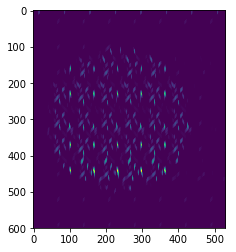

In [21]:
plt.imshow(sum_array)
plt.show()

In [22]:
rescaled = (255.0 / sum_array.max() * (sum_array - sum_array.min())).astype(np.uint8)

im = Image.fromarray(rescaled)
im.save('test.png')